In [48]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [49]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weight_files='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model=InceptionV3(input_shape=(150,150,3),weights=None,include_top=False)
pre_trained_model.load_weights(local_weight_files)

In [36]:
for layer in pre_trained_model.layers:
    layer.trainable=False
    
#pre_trained_model.summary()

last_layer=pre_trained_model.get_layer('mixed7')
last_output=last_layer.output
print("last layer output",last_layer.output_shape)

x=layers.Flatten()(last_output)
x=layers.Dense(1024,activation='relu')(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(1,activation='sigmoid')(x)

last layer output (None, 7, 7, 768)


In [38]:
model=Model(pre_trained_model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [39]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('acc')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training=True

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

#Extract zip            
local_file="horse-or-human.zip" 
zip_ref=zipfile.ZipFile(local_file,'r')
zip_ref.extractall("human-horses/")
zip_ref.close()

local_file="validation-horse-or-human.zip"
zip_ref=zipfile.ZipFile(local_file,'r')
zip_ref.extractall("")
zip_ref.close()

In [43]:
train_horses_dir="human-horses/humans/"
train_humans_dir="human-horses/horses/"

train_horses_names=os.listdir(train_horses_dir)
train_humans_names=os.listdir(train_humans_dir)


validation_horses_dir="validation-horse-or-human/horses/"
validation_humans_dir="validation-horse-or-human/humans/"

validation_horses_names=os.listdir(validation_horses_dir)
validation_humans_names=os.listdir(validation_humans_dir)

In [44]:
print("Horses train images",len(train_horses_names))
print("Humans train images",len(train_humans_names))

print("Horses validation images",len(validation_horses_names))
print("Humans validation images",len(validation_humans_names))

Horses train images 527
Humans train images 500
Horses validation images 128
Humans validation images 128


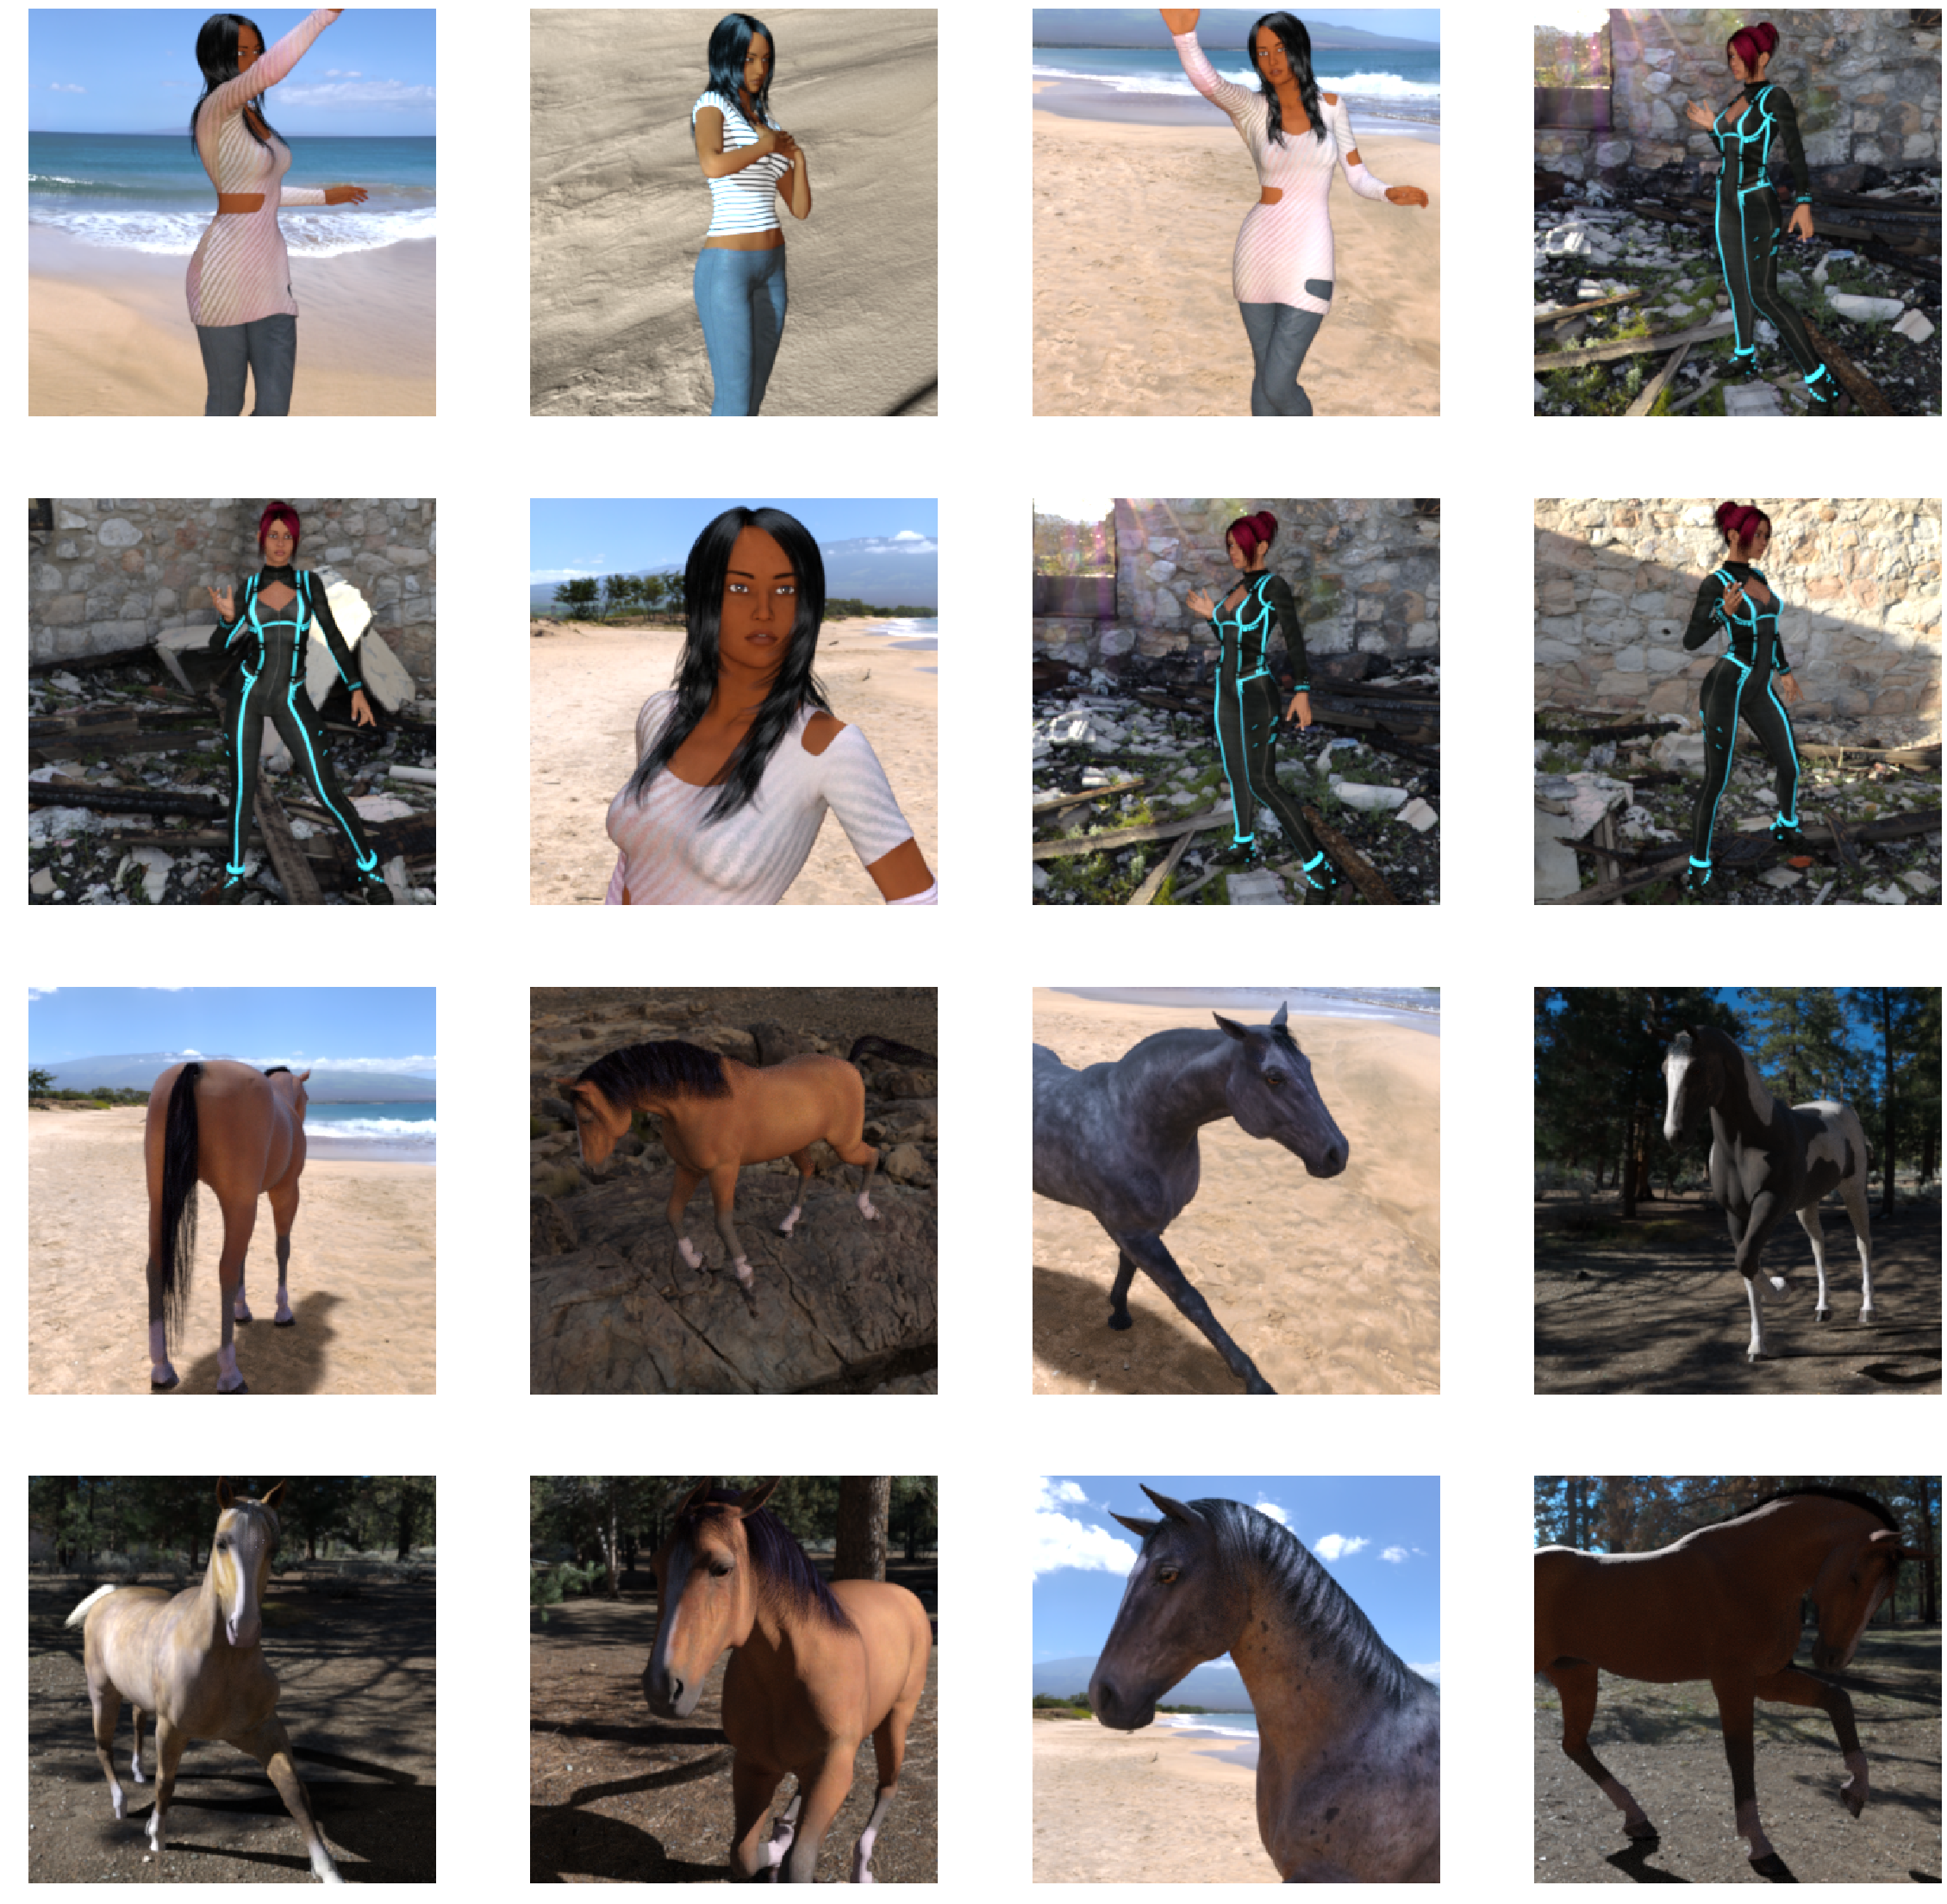

In [50]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0


# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 10, nrows * 10)

pic_index += 8
next_dog_pix = [os.path.join(train_horses_dir, fname) 
                for fname in train_horses_names[pic_index-8:pic_index]]
next_cat_pix = [os.path.join(train_humans_dir, fname) 
                for fname in train_humans_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dog_pix+next_cat_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [51]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 shear_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')


train_generator=train_datagen.flow_from_directory('human-horses/',
                                                 target_size=(150,150),
                                                 batch_size=20,
                                                 class_mode='binary')
                                                
    
validation_datagen=ImageDataGenerator(rescale=1./255)


validation_generator=validation_datagen.flow_from_directory('validation-horse-or-human',
                                                 target_size=(150,150),
                                                 batch_size=20,
                                                 class_mode='binary')
                                                
    

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [52]:
history=model.fit_generator(
                train_generator,
                steps_per_epoch=50,
                epochs=15,
                verbose=2,
                validation_data=validation_generator,
                validation_steps=10)

Epoch 1/15
50/50 - 66s - loss: 0.2664 - acc: 0.8896 - val_loss: 0.0121 - val_acc: 0.9950
Epoch 2/15
50/50 - 55s - loss: 0.1126 - acc: 0.9564 - val_loss: 0.1052 - val_acc: 0.9700
Epoch 3/15
50/50 - 56s - loss: 0.0847 - acc: 0.9686 - val_loss: 3.1070e-04 - val_acc: 1.0000
Epoch 4/15
50/50 - 57s - loss: 0.0504 - acc: 0.9858 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 5/15
50/50 - 57s - loss: 0.0853 - acc: 0.9726 - val_loss: 0.0217 - val_acc: 0.9950
Epoch 6/15
50/50 - 119s - loss: 0.0408 - acc: 0.9868 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 7/15
50/50 - 58s - loss: 0.0339 - acc: 0.9930 - val_loss: 4.0054e-06 - val_acc: 1.0000
Epoch 8/15
50/50 - 59s - loss: 0.0652 - acc: 0.9716 - val_loss: 2.5446e-04 - val_acc: 1.0000
Epoch 9/15
50/50 - 53s - loss: 0.0346 - acc: 0.9887 - val_loss: 0.0972 - val_acc: 0.9750
Epoch 10/15
50/50 - 54s - loss: 0.0271 - acc: 0.9929 - val_loss: 0.0207 - val_acc: 0.9950
Epoch 11/15
50/50 - 55s - loss: 0.0469 - acc: 0.9870 - val_loss: 0.0077 - val_acc: 0.9950
Epoch 

Text(0.5, 1.0, 'Training and validation loss')

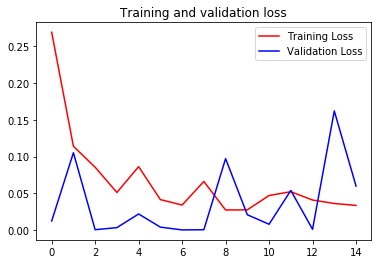

In [56]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r',label= "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b',label= "Validation Loss")
plt.legend()

plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)